In [2]:
import numpy as np
import scipy
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import sys
import time
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from numpy import pi,exp
from math import exp
from matplotlib.legend import Legend
import datetime
import time

np.random.seed(int(time.perf_counter()))
tf.random.set_seed(int(time.perf_counter()))

## for plots
plt.rcParams.update({'font.size': 15})

# Format the date as a string to use in the figure name
now = datetime.datetime.now()
datestr = now.strftime("%Y-%m-%d")
#-------------------------------------------------------------------------------

#prepare the entropy set
folder = "..//lattice_data/"
data_file = folder + "mu_0_WB-EoS.dat"
data = np.loadtxt(data_file,skiprows=1,max_rows=100,usecols=(0,7,8),unpack=True) #DATA FOR muB=0
Tentr = 0.001*data[0] #in GeV
s_T3 = data[1]
Ds_T3 = data[2]

#prepare the chiS
# data_file = folder + "thermo_k4.dat"
# data = np.loadtxt(data_file,skiprows=26,max_rows=91,usecols=(0,1,2,3,4,5,6,7,8,9,12,13),unpack=True) #DATA FOR muB=0
# muB_T = data[0]
# TchiS = 0.001*data[1] #in GeV
# chiS = data[10]
# DchiS = data[11]
######## new data 2202.05574v1
data_file = folder + "eos_chis_22.dat"
data = np.loadtxt(data_file,skiprows=1,usecols=(0,1,12,13),unpack=True) #DATA FOR muB=0
muB_T = data[0]
TchiS = 0.001*data[1] #in GeV
chiS = data[2]
DchiS = data[3]

datanew = folder + "chi2_table_1112.txt"
data = np.loadtxt(datanew,skiprows=1,usecols=(0,7,8,9,10),unpack=True) #muB=0 same temperature range
Tnew = 0.001*data[0]
selection = (Tnew > np.max(TchiS))
Tchis_ = Tnew[selection]
chis_ = data[1]
chis_ = chis_[selection]
Dchis_ = data[2]
Dchis_ = Dchis_[selection]
TchiS = np.concatenate((TchiS,Tchis_))
chiS = np.concatenate((chiS,chis_))
DchiS = np.concatenate((DchiS,Dchis_))


#prepare the chib set
data_file = folder + "chiB2.dat"
data_chib = np.loadtxt(data_file,skiprows=5,max_rows=100,usecols=(0,1,2),unpack=True) #muB=0 same temperature range
TchiB = 0.001*data_chib[0]
chiB = data_chib[1]
DchiB = data_chib[2]


#TEMPERATURE CUTS MUST BE CHOSED ACCORDING TO THE TABLE USED TO TRAIN THE SURROGATE. FOR T<T_min, WHERE T_min IS THE MINIMUM VALUE OF T IN THE TABLE, THE SURROGATE IS NOT RELIABLE!
#(THE SAME APPLIES FOR T>T_max)
T_min = 0.155
test_size = 0.2

def split_data(T, Data, error, test_size, T_min):
  #splits the data in training and validation samples in a temperature interval T>T_min
    temperature_cut = (T > T_min)[:len(Data)]
    data_and_errors = np.stack((Data[temperature_cut], error[temperature_cut]),axis=1)
    training_T, validation_T, D_train, D_val = train_test_split(T[temperature_cut], data_and_errors, test_size=test_size)

    training_T = tf.constant(training_T, dtype=tf.float32)
    validation_T = tf.constant(validation_T, dtype=tf.float32)
    D_train = tf.constant(D_train, dtype=tf.float32)
    D_val = tf.constant(D_val, dtype=tf.float32)

    return training_T, validation_T, D_train, D_val


training_Temp_entr, validation_Temp_entr, entr_train, entr_val = split_data(Tentr,s_T3,  Ds_T3, test_size, T_min)
training_Temp_chiS, validation_Temp_chiS, chiS_train, chiS_val = split_data(TchiS, chiS, DchiS, test_size, T_min)
training_Temp_chib, validation_Temp_chib, chib_train, chib_val = split_data(TchiB, chiB, DchiB, test_size, T_min)

### There are two surrogates, one for integrals involved in the entropy and one for those of the susceptibilities. surrogate_entropy[0] and [1] are Ib and If respectively and
### surrogate_chiq is used for the susceptibilities. As input they expect [T,moT,woT] i.e. Temperature, mass/Temperature and width/Temperature
###
surrogate_entropy_loaded = tf.keras.models.load_model('..//surrogate_entropy_math.h5') #THE SURROGATES *ONLY* EVALUATE THE INTEGRALS IN THE FORMULAE
surrogate_chiq_loaded = tf.keras.models.load_model('..//surrogate_chi_math.h5')


#The surrogate has been trained on normalized data! These values must be used to put it back to the real range of values
max_Ib = 0.183902
max_If = 0.132398
max_chi = 0.133045

#DEGENERACY FACTORS
dg = 16 #gluon
dq = 6 #quark

In [3]:
## thermodynamics

def s(T):
  temp = tf.constant(np.array([T]),dtype=tf.float32)
  return entropy_T3(temp).numpy()[0]*T**3

def pres(T):
  P0 = 0.00047569             # p_T4[TchiS==0.158]*0.158**4
  T0 = 0.158
  P = P0 + scipy.integrate.quad(s,T0,T,limit=100)[0]
  return P

def energy(T):
  return T*s(T)-pres(T)

def I(T):
  return e(T)-3*pres(T)

def cs(T):
  dT = 0.001
  ds = (s(T+dT)-s(T))/dT

  cS = s(T)/(T*ds)

  return cS

def dmg_dT(T):
  dT = 0.001
  T1 = tf.constant([T+dT],dtype=tf.float32)
  T0 = tf.constant([T],dtype=tf.float32)

  dmg = (gluon(T1).numpy()*(T+dT)-gluon(T0).numpy()*(T))/dT

  return dmg

def dml_dT(T):
  dT = 0.001
  muoT1 = tf.constant([T+dT],dtype=tf.float32)
  muoT0 = tf.constant([T],dtype=tf.float32)

  dml = (light(muoT1).numpy()*(T+dT)-light(muoT0).numpy()*(T))/dT

  return dml

def dms_dT(T):
  dT = 0.001
  muoT1 = tf.constant([T+dT],dtype=tf.float32)
  muoT0 = tf.constant([T],dtype=tf.float32)

  dms = (strange(muoT1).numpy()*(T+dT)-strange(muoT0).numpy()*(T))/dT

  return dms


##from Kubo
def dfa(fi,E,T,mu):
      sign = np.sign(fi)
      if (fi == 10):
            dfa=1/(np.exp(E/T)-1)  # Bose-Einstein
      else:
        dfa = 1/(np.exp((E-sign*mu)/T)+1)  # Fermi-Dirac
      return dfa


###  spectral function
def rhorel(om,p,m,gam):
    p0 = np.sqrt(p**2+m**2-gam**2)
    rho = gam/p0*(1./((om-p0)**2+gam**2)-1./((om+p0)**2+gam**2))

    return rho
###
def fetaq(om,p,T,ml,ms,m,gaml,gams,gam):
    Nc= 3
    mu = 0
    angular_pref = 1/(30*T)
    ps = 7*om**4-10*om**2*p**2+7*p**4
    fq = 2*rhorel(om,p,ml,gaml)**2 + rhorel(om,p,ms,gams)**2# 2=u+d + s
    ffblock = 2*2*Nc*(dfa(+1,om,T,mu)*(1 - dfa(+1,om,T,mu)))
    etaq = angular_pref*p**2*(1/(2*pi**3)*16/(np.exp(om/(2*T))-np.exp(-om/(2*T)))**2*rhorel(om,p,m,gam)**2*ps + 1/(2*pi**3)*p**4*ffblock*fq)
    return etaq

##conductivity for one specie
def fcond_q(om,p,T,m,gam):
    pref = 1/(4*pi**3)
    qq = 4*pi/137
    Nc= 3
    mu = 0
    ffblock = 2*Nc*(dfa(+1,om,T,mu)*(1 - dfa(+1,om,T,mu))+ dfa(-1,om,T,mu)*(1.-dfa(-1,om,T,mu)))
    sigm = pref*qq*ffblock*(p**2*om**2)*rhorel(om,p,m,gam)**2
    return sigm

##eta over s
def eta_s(T):
  muoT = tf.constant([T],dtype=tf.float32)

  mass_gluon = gluon(muoT)[0].numpy()*T
  mass_light = light(muoT)[0].numpy()*T
  mass_strange = strange(muoT)[0].numpy()*T

  width_gluon = width_g(muoT)[0].numpy()*T
  width_light = width_q(muoT)[0].numpy()*T
  width_strange = width_s(muoT)[0].numpy()*T


  eta =scipy.integrate.dblquad(fetaq, 0, np.inf, 0, np.inf, args = (T, mass_light,mass_strange,mass_gluon ,width_light,width_strange,width_gluon))
  eta_s = eta[0]/s(T)

  print(eta_s, " ",eta[1]/s(T))

  return eta_s

def fcond_full(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)
  ml = light(muoT)[0].numpy()*T
  ms = strange(muoT)[0].numpy()*T
  gamq = width_q(muoT)[0].numpy()*T
  gams = width_s(muoT)[0].numpy()*T
  cond_light = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ml ,gamq))
  cond_s = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ms ,gams))
  cond_full = (5/9*cond_light[0] + 1/9*cond_s[0])/(3*T) ## factors 5/9 -refers to u+d ,1/9 - q^2
##full conductivity - summ (u+d) and s quarks contribution
  return cond_full/T

def fcond_light(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)

  ml = light(muoT)[0].numpy()*T
  gamq = width_q(muoT)[0].numpy()*T

  cond_light = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ml ,gamq))
  cond_full = 5/9*cond_light[0]/(3*T) ## factors 5/9 -refers to el charge u+d
##full conductivity - summ (u+d) and s quarks contribution
  return cond_full/T

def fcond_strange(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)
  ms = strange(muoT)[0].numpy()*T
  gams = width_s(muoT)[0].numpy()*T
  cond_s = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ms ,gams))
  cond_full = 1/9*cond_s[0]/(3*T) #1/9 - el charge s-quark

  return cond_full/T


## Olga's fit of the data ->
def chi2B_WB(Temp):
    t = Temp/0.2
    h3 = -0.5
    h4 = 0.6420
    f3 = 0.1420
    f4 = 7.0789
    f5 = -5.32284
    chi2 = tf.math.exp(-h3/t - h4/t**2)*f3*(tf.math.tanh(f4*t + f5) + 1.)
    return chi2

def chi2S_WB(Temp):
    t = Temp/0.2
    h3 = 0.75
    h4 = -0.2810
    f3 = 0.6173
    f4 = 4.8306
    f5 = -4.0393
    chi2s = tf.math.exp(-h3/t - h4/t**2)*f3*(tf.math.tanh(f4*t + f5) + 1.)
    return chi2s

**from O.S.: 19.09 m = Ag with 6 parameters**


*   widths are independent
*   delta m = 0.03



**1. Original AG NN DQPM with weights from 14.09**

In [9]:
## new asymptotics  -> params
# fix_seed=123
from tensorflow.keras import initializers
# initializer_choice = 1
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)#seed = fix_seed)
# ####check
# w1 = initializer((2, 2))

# print(w1)
####check

custom_activation = tf.keras.layers.Lambda(lambda x: tf.square(x), name='custom_activation_square')

def makemodel(initializer_):
  quasiparticle = tf.keras.Sequential()
  quasiparticle.add( tf.keras.layers.Dense(24,activation="sigmoid",kernel_initializer=initializer))
  #quasiparticle.add(tf.keras.layers.Dropout(0.5),)
  quasiparticle.add( tf.keras.layers.Dense(12,activation="sigmoid",kernel_initializer=initializer))
  #quasiparticle.add(tf.keras.layers.Dropout(0.5),)
  quasiparticle.add( tf.keras.layers.Dense(12,activation="sigmoid",kernel_initializer=initializer))
  quasiparticle.add( tf.keras.layers.Dense(6,activation=custom_activation ,kernel_initializer=initializer_)) # g^2
  return quasiparticle

# quasiparticle.build ( input_shape =(None,1) ) #building the model. The initial 'None' is because it can be a list of such arrays

def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

# quasiparticle = makemodel(initializer)
# quasiparticle.build ( input_shape =(None,1) )

def g_nn(temp_muoT):
  g = quasiparticle(temp_muoT)[:,2]
  return g


def gluon(temp_muoT):
  mg_T = quasiparticle(temp_muoT)[:,0]*g_nn(temp_muoT)
  return mg_T


def light(temp_muoT):
  ml_T = quasiparticle(temp_muoT)[:,1]*g_nn(temp_muoT)
  return ml_T


def strange(temp_muoT):
  dms =0.03
  ms_T = light(temp_muoT)+dms/temp_muoT
  return ms_T


def width_g(temp_muoT):
  wg_T = quasiparticle(temp_muoT)[:,3]
  return wg_T


def width_q(temp_muoT):
  wq_T = quasiparticle(temp_muoT)[:,4]
  return wq_T


def width_s(temp_muoT):
  ws_T = quasiparticle(temp_muoT)[:,5]
  return ws_T


def entropy_T3(temp_muoT):
  mg_T = gluon(temp_muoT)
  ml_T = light(temp_muoT)
  ms_T = strange(temp_muoT)
  wg_T = width_g(temp_muoT)
  wq_T = width_q(temp_muoT)
  ws_T = width_s(temp_muoT)

  gluons_ = tf.stack([temp_muoT,mg_T,wg_T],axis=1)
  lightq_ = tf.stack([temp_muoT,ml_T,wq_T],axis=1)
  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  Ib = max_Ib*surrogate_entropy_loaded(gluons_)[:,0]
  IfL = max_If*surrogate_entropy_loaded(lightq_)[:,1]
  IfS = max_If*surrogate_entropy_loaded(strangeq_)[:,1]

  entropy_ = dg*Ib+2*(2*dq*IfL+dq*IfS) #the 2 in front of IfL is to count up and down separately

  return entropy_/temp_muoT**3


def chib_T2(temp_muoT):
  ml_T = light(temp_muoT)
  ms_T = strange(temp_muoT)
  wq_T = width_q(temp_muoT)
  ws_T = width_s(temp_muoT)

  lightq_ = tf.stack([temp_muoT,ml_T,wq_T],axis=1)
  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  chib_light = max_chi*surrogate_chiq_loaded(lightq_)[:,0]
  chib_strange = max_chi*surrogate_chiq_loaded(strangeq_)[:,0]
  chioT2 = (2*dq* chib_light + dq* chib_strange)/9 #the 2 in front of IfL is to count up and down separately

  return chioT2/temp_muoT**2


def chis_T2(temp_muoT):
  ms_T = strange(temp_muoT)
  ws_T = width_s(temp_muoT)

  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  chis_strange = max_chi*surrogate_chiq_loaded(strangeq_)[:,0]
  chiS = dq*chis_strange

  return chiS/temp_muoT**2


def error_entr(temp_muoT,data):
  Tc=0.158
  return tf.math.reduce_mean(((entropy_T3(temp_muoT)-data[:,0]))**2/data[:,1]**2)


def error_chib(temp_muoT,data):
  Tc=0.158
  err_data = tf.math.reduce_mean(((chib_T2(temp_muoT)-data[:,0]))**2/(data[:,1])**2)

  return err_data


def error_chis(temp_muoT,data):
  Tc=0.158
  err_data = tf.math.reduce_mean(((chis_T2(temp_muoT)-data[:,0]))**2/(data[:,1])**2)
  return err_data


def get_dqpm():
  Tc=0.158
  Tmin =Tc
  temp_check = tf.constant(np.linspace(Tmin,3.2*Tc,500),dtype=tf.float32)
  # temp_check2 = tf.constant(np.linspace(2*Tmin,4*Tc,500),dtype=tf.float32)
  cm = 14.4
  pref = 0.333
  wmass = 10
  widnn_g  = pref*3/(8*np.pi) *g_nn(temp_check)**2 *tf.math.log(2*cm/(g_nn(temp_check)**2)+1)
  widnn_q = pref* 1/(6*np.pi) *g_nn(temp_check)**2 *(tf.math.log(2*cm/(g_nn(temp_check)**2)+1))

  asymptotics = tf.math.reduce_mean((width_g(temp_check)-widnn_g)**2 )
  asymptotics = asymptotics + tf.math.reduce_mean((width_q(temp_check)-widnn_q)**2)
  asymptotics = asymptotics + tf.math.reduce_mean((width_s(temp_check)- widnn_q )**2)
  asymptotics = asymptotics + wmass*tf.math.reduce_mean((quasiparticle(temp_check)[:,0]-tf.math.sqrt(3/4))**2)
  asymptotics = asymptotics + wmass*tf.math.reduce_mean((quasiparticle(temp_check)[:,1]-tf.math.sqrt(1/3))**2)
  return asymptotics

############## artifictially made for high T fit - not lQCD data

def highT_chis(temp_muoT):
  delta_chis = 0.03*chi2S_WB(temp_muoT)
  error = tf.math.reduce_mean(((chis_T2(temp_muoT)-chi2S_WB(temp_muoT)))**2/delta_chis**2)
  return  error#


def highT_chib(temp_muoT):
  delta_chib = 0.03*chi2B_WB(temp_muoT)
  error = tf.math.reduce_mean(((chib_T2(temp_muoT)-chi2B_WB(temp_muoT)))**2/delta_chib**2)
  return  error#
##############

def mass_asy():
  Tc=0.158
  temp_check = tf.constant(np.linspace(1.75*Tc,4*Tc,500),dtype=tf.float32)
  asymptotics = tf.math.reduce_mean((quasiparticle(temp_check)[:,0]-tf.math.sqrt(3/4))**2)
  asymptotics = asymptotics + tf.math.reduce_mean((quasiparticle(temp_check)[:,1]-tf.math.sqrt(1/3))**2)
  return asymptotics

def width_asy():
  Tc=0.158
  temp_check = tf.constant(np.linspace(Tc,4*Tc,500),dtype=tf.float32)
  asymptotics = tf.math.reduce_mean((width_g(temp_check)/width_q(temp_check)-3/4)**2)
  return asymptotics



def deltam_error():
  #standart dqpm 0.03
  dms =0.15
  Tc=0.158
  Tmin = 2.5*Tc
  temp_check = tf.constant(np.linspace(Tmin,4*Tc,500),dtype=tf.float32)
  deltam_err = tf.math.reduce_mean((quasiparticle(temp_check)[:,2]-dms/temp_check)**2)
  return deltam_err

def samewidths_error():
  #standart dqpm 0.03
  Tc=0.158
  Tmin = 3.0*Tc
  temp_check = tf.constant(np.linspace(Tmin,4*Tc,500),dtype=tf.float32)
  deltam_err = tf.math.reduce_mean((quasiparticle(temp_check)[:,4]/quasiparticle(temp_check)[:,5]-1)**2)
  return deltam_err

##SETUP C
# b_entr = 2000
# b_chib = 1
# b_asy = 1e5
# b_chis = 0.2
# b_dqpm = 1e4
# b_mass = 1e5

##SETUP B
b_entr = 500
b_chib = 1
b_asy = 1e5
b_chis = 1
b_dqpm = 1e4
b_mass = 1e5

##SETUP A
# b_entr = 100
# b_chib = 1
# b_asy = 1e5
# b_chis = 1
# b_dqpm = 1e3
# b_mass = 1e5

def quasiparticle_coupl_loss(temp_entr,data_entr,temp_chis,data_chis,temp_chib, data_chib):
  error_entropy = error_entr(temp_entr,data_entr)
  error_chiB = error_chib(temp_chib,data_chib)
  error_chiS = error_chis(temp_chis,data_chis)
  Tc=0.158
  high_T = tf.constant(np.linspace(2.5*Tc,4*Tc,400),dtype=tf.float32)
  dm_err = deltam_error()
#-----------parameters with sigma included


  return b_entr*error_entropy  + b_chis*error_chiS + b_chib*error_chiB  + b_dqpm*get_dqpm()#+ b_asy*mass_asy()#+ b_asy*samewidths_error()


# eta = 0.005
# optimizer = tf.optimizers.Adam(learning_rate=eta)
# scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta, decay_steps=500, decay_rate=0.95)
# optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)

eta = 0.005
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta, decay_steps=1000, decay_rate=0.95)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)

@tf.function
def quasiparticle_coupl_train(temp_entr,data_entr,temp_chis,data_chis,temp_chib, data_chib):
  with tf.GradientTape() as gt:
    gt.watch ( quasiparticle.variables )
    loss_ = quasiparticle_coupl_loss(temp_entr,data_entr,temp_chis,data_chis,temp_chib, data_chib)#+ wi_as*asy_loss()
    grads = gt.gradient (loss_, quasiparticle.variables)
    optimizer.apply_gradients (zip(grads, quasiparticle.variables))
    return loss_


In [10]:
fix_seed = np.random.randint(-10000,10000)
initializer = tf.keras.initializers.GlorotUniform(seed=fix_seed)
tf.keras.backend.clear_session()
quasiparticle = makemodel(initializer)
quasiparticle.build ( input_shape =(None,1) )
dentr = error_entr(training_Temp_entr,entr_train).numpy()/error_chib(training_Temp_chib,chib_train).numpy()
dchis = error_chis(training_Temp_chiS,chiS_train).numpy()/error_chib(training_Temp_chib,chib_train).numpy()
#AAAAAAAAAAAA = get_g_asy().numpy()/error_chib(training_Temp_chib,chib_train).numpy()
ddqpm = get_dqpm().numpy()/error_chib(training_Temp_chib,chib_train).numpy()
dm = deltam_error().numpy()/error_chib(training_Temp_chib,chib_train).numpy()

print("dS=",b_entr*dentr,"dchiS=",b_chis*dchis,"ddqpm=",b_dqpm*ddqpm,"dm=",1*dm)

dS= 64.02606517076492 dchiS= 7.860071659088135 ddqpm= 19.060245249420404 dm= 1.4040295354789123e-05


899
 100% [====================================================================================================>] Number: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


loss training:  tf.Tensor(6151.916, shape=(), dtype=float32)
loss validation:  tf.Tensor(6201.621, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


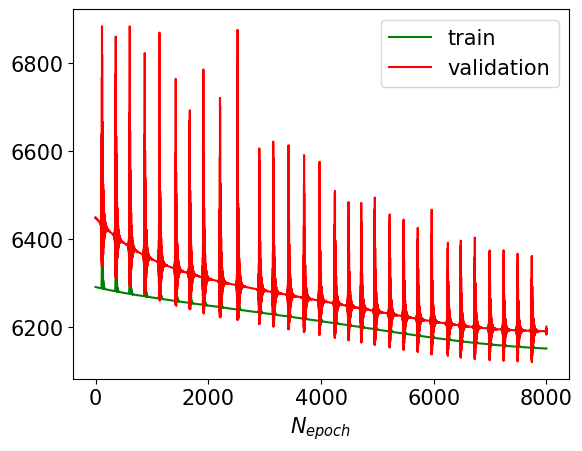

-8921
 100% [====================================================================================================>] Number: 1

loss training:  tf.Tensor(6155.975, shape=(), dtype=float32)
loss validation:  tf.Tensor(6186.567, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


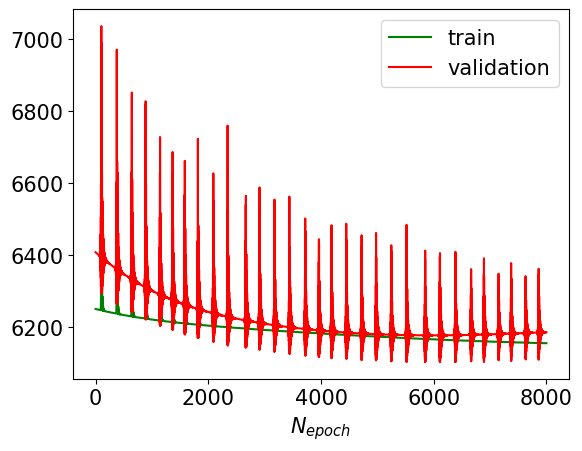

5570
 100% [====================================================================================================>] Number: 2

loss training:  tf.Tensor(6138.4756, shape=(), dtype=float32)
loss validation:  tf.Tensor(6140.33, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


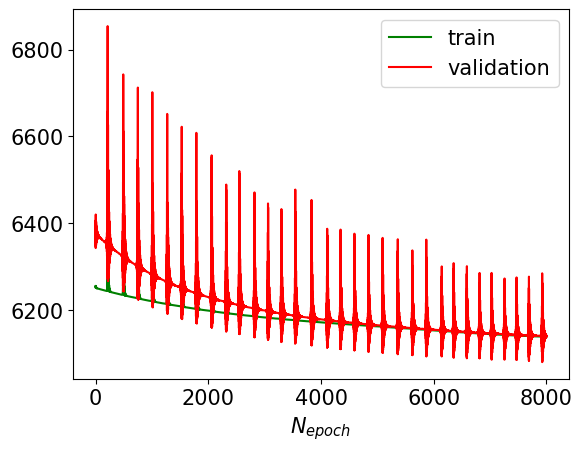

-7510
 100% [====================================================================================================>] Number: 3

loss training:  tf.Tensor(6189.829, shape=(), dtype=float32)
loss validation:  tf.Tensor(6227.324, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


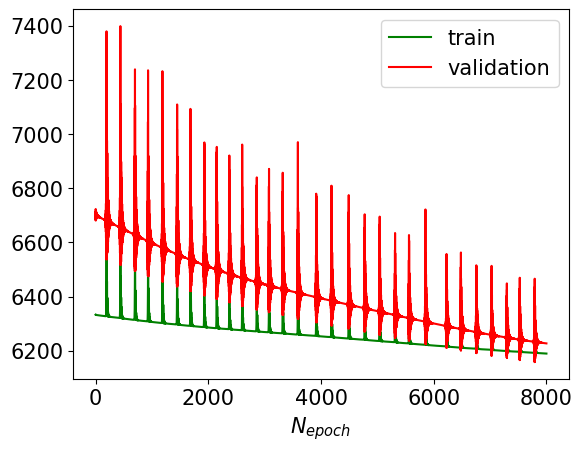

-6765
 100% [====================================================================================================>] Number: 4loss training:  

tf.Tensor(6117.257, shape=(), dtype=float32)
loss validation:  tf.Tensor(6107.1377, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


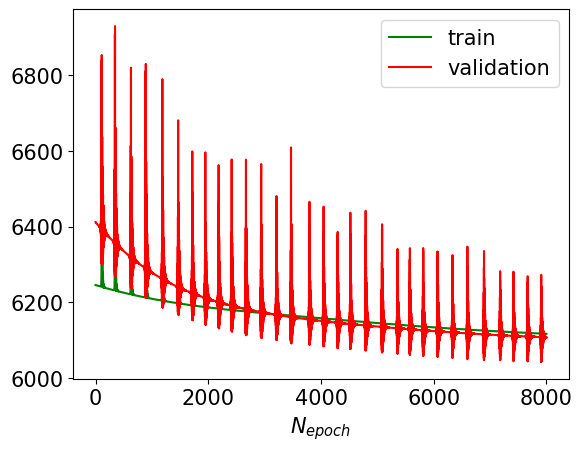

7016
 100% [====================================================================================================>] Number: 5

loss training:  tf.Tensor(6110.515, shape=(), dtype=float32)
loss validation:  tf.Tensor(6164.584, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


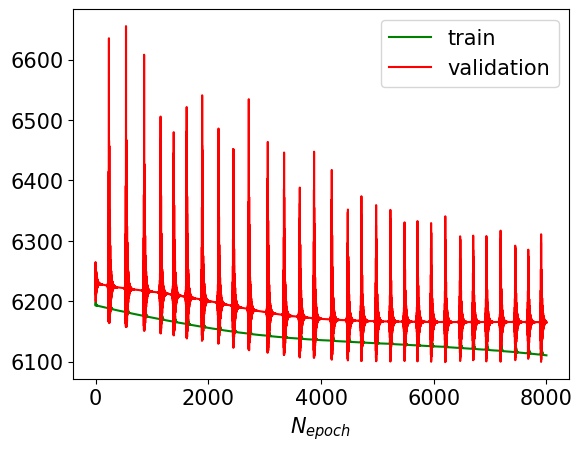

258
 100% [====================================================================================================>] Number: 6

loss training:  tf.Tensor(6053.703, shape=(), dtype=float32)
loss validation:  tf.Tensor(6100.7, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


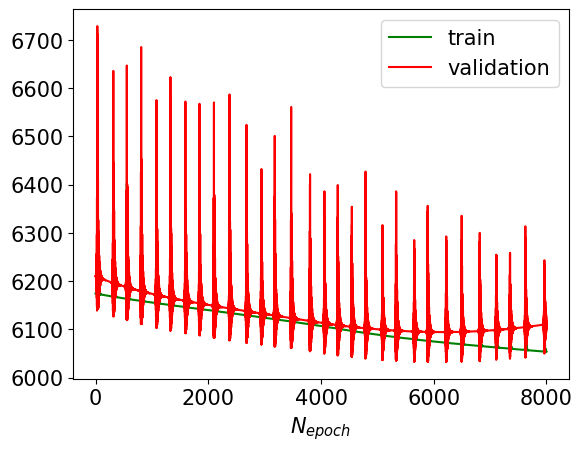

-4211
 100% [====================================================================================================>] Number: 7

loss training:  tf.Tensor(6139.21, shape=(), dtype=float32)
loss validation:  tf.Tensor(6179.911, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


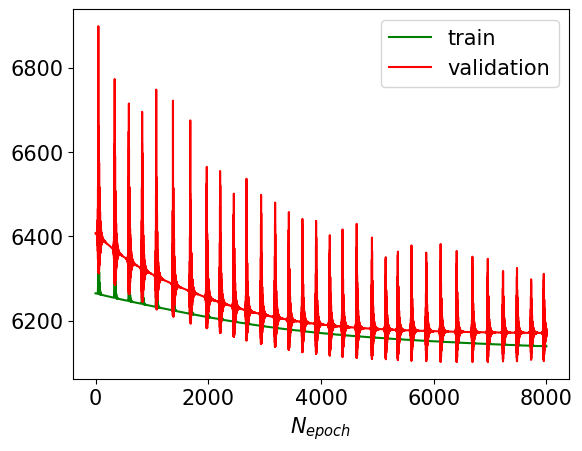

4693
 100% [====================================================================================================>] Number: 8

loss training:  tf.Tensor(6162.852, shape=(), dtype=float32)
loss validation:  tf.Tensor(6177.671, shape=(), dtype=float32)
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.001412296>


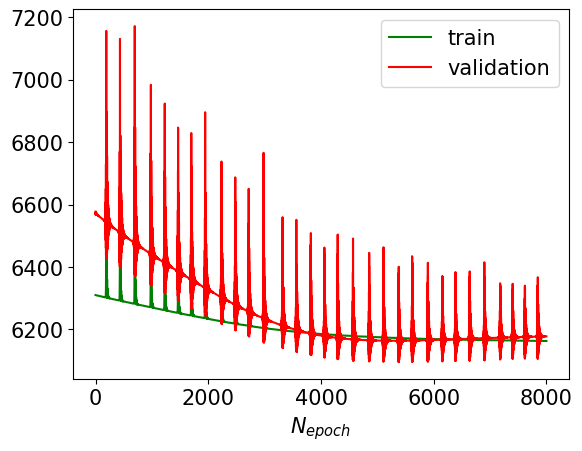

4300
 45% [=============================================>......................................................] Number: 9

KeyboardInterrupt: ignored

In [11]:
#
# dms = 0.03
times = 10
for bunch_of_times in range(times):
  fix_seed = np.random.randint(-10000,10000)
  initializer = tf.keras.initializers.GlorotUniform(seed=fix_seed)
  tf.keras.backend.clear_session()
  quasiparticle = makemodel(initializer)

  quasiparticle.build ( input_shape =(None,1) )
  optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
  reinitialize(quasiparticle)
  initializer = tf.keras.initializers.GlorotUniform(seed=fix_seed)
  quasiparticle = makemodel(initializer)

  quasiparticle.build ( input_shape =(None,1) )
  scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=eta, decay_steps=1000, decay_rate=0.90)
  optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
  print(fix_seed)
  @tf.function
  def quasiparticle_coupl_train(temp_entr,data_entr,temp_chis,data_chis,temp_chib, data_chib):
    with tf.GradientTape() as gt:
      gt.watch ( quasiparticle.variables )
      loss_ = quasiparticle_coupl_loss(temp_entr,data_entr,temp_chis,data_chis,temp_chib, data_chib)#+ wi_as*asy_loss()
      grads = gt.gradient (loss_, quasiparticle.variables)
      optimizer.apply_gradients (zip(grads, quasiparticle.variables))
      return loss_
  # weights = quasiparticle.get_weights()
  # print(weights)
  #Training stage
  epoch = 12000
  loss_train = []
  loss_validation=[]
  for i in range(epoch):
    #training and appending the losses in the lists
    loss_train.append (quasiparticle_coupl_train(training_Temp_entr,entr_train,training_Temp_chiS,chiS_train,training_Temp_chib,chib_train) )
    loss_validation.append(quasiparticle_coupl_loss(validation_Temp_entr,entr_val,validation_Temp_chiS,chiS_val,validation_Temp_chib,chib_val) )
    #the following snippet prints a progress bar for the training
    row = "["+"="*int(100/epoch *(i+1)) + ">"+"."*(int(100-100/epoch *(i+1)))+"]"
    sys.stdout.write("\r %d%% %s " %( int(100/epoch *(i + 1)),row))
    sys.stdout.write("Number: " +str(bunch_of_times))
    sys.stdout.flush()
  print("loss training: ", loss_train[-1])
  print("loss validation: ", loss_validation[-1])
  print(optimizer.learning_rate)
  model_path = f'./setupB_12k/seed_{fix_seed}_bentr_{b_entr}_b_chis_{b_chis}_b_dqpm_{b_dqpm}.h5'
  quasiparticle.save(model_path)
  plt.subplots()
  plt.plot (loss_train[4000:], 'g',label = 'train' )
  plt.plot(loss_validation[4000:],'r', label = 'validation' )
  plt.xlabel('$N_{epoch}$')
  plt.legend()
  plt.show()
